In [17]:
import pathlib
from pedpy.io.trajectory_loader import load_trajectory
from pedpy.data.geometry import MeasurementLine, WalkableArea
from pedpy.methods.method_utils import compute_individual_voronoi_polygons, Cutoff
from pedpy.column_identifier import (
    ID_COL,
    FRAME_COL,
    X_COL,
    Y_COL,
    POINT_COL,
    DENSITY_COL,
    SPECIES_COL,
    DENSITY_SP1_COL,
    DENSITY_SP2_COL,
    V_SP1_COL,
    V_SP2_COL,
    VELOCITY_COL,
    FLOW_SP1_COL,
    FLOW_SP2_COL,
    FLOW_COL,
)

from shapely import Polygon
import matplotlib.pyplot as plt
from pedpy.plotting.plotting import plot_measurement_setup, plot_density
from pedpy.methods.flow_calculator import separate_species, calc_speed_on_line, calc_density_on_line, calc_flow_on_line
from pedpy.methods.speed_calculator import compute_individual_speed

In [18]:
pedpy_blue = (89 / 255, 178 / 255, 216 / 255)
pedpy_orange = (220 / 255, 160 / 255, 73 / 255)
pedpy_green = (108 / 255, 190 / 255, 167 / 255)
pedpy_petrol = (98 / 255, 190 / 255, 190 / 255)
pedpy_grey = (114 / 255, 125 / 255, 139 / 255)
pedpy_red = (233 / 255, 117 / 255, 134 / 255)

In [19]:
from pedpy.io.trajectory_loader import TrajectoryUnit

traj_paths = ("demo-data/bi-directional/bi_corr_400_b_08.txt",
              "demo-data/bottleneck/040_c_56_h-.txt",
              "demo-data/bi-directional/bi_corr_400_b_03.txt", 
              "demo-data/uni-directional/traj_UNI_CORR_500_08.txt",
              "demo-data/uni-directional/traj_UNI_CORR_500_03.txt"
              )
selected_traj = traj_paths[2]


if selected_traj == traj_paths[0]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    walkable_area = WalkableArea(
        # complete area
        [
            (-6.0, 0),
            (5, 0),
            (5, 4),
            (-6, 4)
        ])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 4.0)])
    poly1 = Polygon([(-6, 0), (-4, 0), (-4, 4), (-6, 4)])
    poly2 = Polygon([(3, 0), (5, 0), (5, 4), (3, 4)])
elif selected_traj == traj_paths[1]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    poly2 = Polygon([(3.5, -2), (3.5, 8), (-3.5, 8), (-3.5, -2)])
    poly1 = Polygon()
    walkable_area = WalkableArea(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    obstacles=[
        # left barrier
        [
            (-0.7, -1.1),
            (-0.25, -1.1),
            (-0.25, -0.15),
            (-0.4, 0.0),
            (-2.8, 0.0),
            (-2.8, 6.7),
            (-3.05, 6.7),
            (-3.05, -0.3),
            (-0.7, -0.3),
            (-0.7, -1.0),
        ],
        # right barrier
        [
            (0.25, -1.1),
            (0.7, -1.1),
            (0.7, -0.3),
            (3.05, -0.3),
            (3.05, 6.7),
            (2.8, 6.7),
            (2.8, 0.0),
            (0.4, 0.0),
            (0.25, -0.15),
            (0.25, -1.1),
        ],
    ],)
    
    measurement_line = MeasurementLine([(0.25, 0), (-0.25, 0)])
elif selected_traj == traj_paths[2]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    walkable_area = WalkableArea(
        # complete area
        [
            (-6.0, -0.5),
            (5, 0),
            (5, 4),
            (-6, 4.5)
        ])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 4.0)])
    poly1 = Polygon([(-6, -0.5), (-4, -0.5), (-4, 4.5), (-6, 4.5)])
    poly2 = Polygon([(3, -0.5), (5, -0.5), (5, 4.5), (3, 4.5)])
elif selected_traj == traj_paths[3]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj), default_unit=TrajectoryUnit.METER
    )
    walkable_area = WalkableArea(
        # complete area
        [
            (-5.5, 0),
            (5, 0),
            (5, 5),
            (-5.5, 5)
        ])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 5)])
    poly1 = Polygon([(-6, 0), (-4, 0), (-4, 5), (-6, 5)])
    poly2 = Polygon([(3, 0), (5, 0), (5, 5), (3, 5)])
elif selected_traj == traj_paths[4]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj), default_unit=TrajectoryUnit.METER
    )
    walkable_area = WalkableArea(
        # complete area
        [
            (-5.5, 0),
            (5, 0),
            (5, 5),
            (-5.5, 5)
        ])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 5)])
    poly1 = Polygon([(-6, 0), (-4, 0), (-4, 5), (-6, 5)])
    poly2 = Polygon([(3, 0), (5, 0), (5, 5), (3, 5)])
else:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    raise f"for the selected traj is no walkable area defined"

In [20]:
individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [21]:
individual_speed = compute_individual_speed(
    traj_data=traj,
    frame_step=25,
    compute_velocity=True,
)

In [22]:
species = separate_species(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, individual_speed=individual_speed)
individual_speed = compute_individual_speed(
    traj_data=traj,
    frame_step=1,
    compute_velocity=True,
)

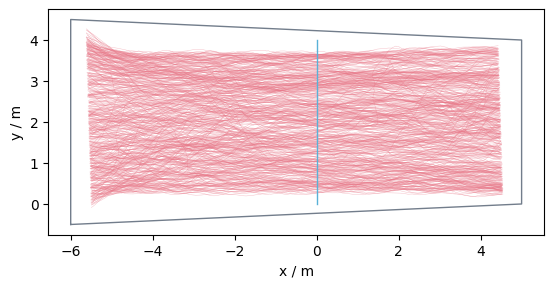

In [23]:
plot_measurement_setup(
    traj=traj,
    walkable_area=walkable_area,
    traj_alpha=0.5,
    traj_width=0.3,
    measurement_lines=[measurement_line],
    ma_line_width=2,
    ma_alpha=0.5,
).set_aspect("equal")

plt.show()

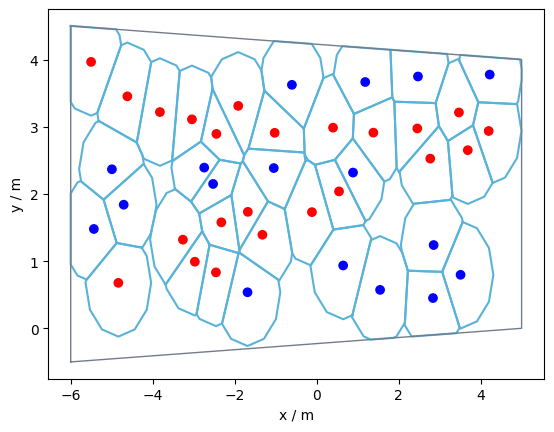

In [24]:
from pedpy.plotting.plotting import plot_voronoi_cells
import numpy as np

frame = 1000

plot_voronoi_cells(voronoi_data=individual_cutoff, frame=frame, traj_data=traj, walkable_area=walkable_area)
positions = traj.data.merge(species[[ID_COL, SPECIES_COL]], on=ID_COL, how='left') 

positions['color'] = np.where(positions[SPECIES_COL] == 1, "b", "r")
idx = positions[(positions[FRAME_COL] == frame)]
plt.scatter(idx[X_COL], idx[Y_COL], c=idx["color"])
plt.show()

In [25]:
for frame in range(0, 0, 10):
    plt.clf()
    plot_voronoi_cells(voronoi_data=individual_cutoff, frame=frame, traj_data=traj, walkable_area=walkable_area)
    idx = positions[(positions[FRAME_COL] == frame)]
    plt.scatter(idx[X_COL], idx[Y_COL], c=idx["color"])
    print(frame)
    plt.savefig(f"delete_soon/{frame}_bi.png")


In [26]:
default_linewidth = 0.5
def plot_speed_at_line(speed_on_line, line_width=default_linewidth):
    plt.plot(speed_on_line[FRAME_COL], speed_on_line[V_SP1_COL], label='species 1', linewidth=line_width) 
    plt.plot(speed_on_line[FRAME_COL], speed_on_line[V_SP2_COL], label='species 2', linewidth=line_width)
    plt.plot(speed_on_line[FRAME_COL], speed_on_line[VELOCITY_COL], label='total', linewidth=line_width)
    plt.xlabel('frame')
    plt.ylabel('velocity on line')
    plt.legend()

def plot_density_at_line(density_on_line, line_width=default_linewidth):
    plt.plot(density_on_line[FRAME_COL], density_on_line[DENSITY_SP1_COL], label='species 1', linewidth=line_width) 
    plt.plot(density_on_line[FRAME_COL], density_on_line[DENSITY_SP2_COL], label='species 2', linewidth=line_width)
    plt.plot(density_on_line[FRAME_COL], density_on_line[DENSITY_COL], label='total', linewidth=line_width)
    plt.xlabel('frame')
    plt.ylabel('density on line')
    plt.legend()
    
def plot_flow_at_line(flow_on_line, line_width=default_linewidth):
    plt.plot(flow_on_line[FRAME_COL], flow_on_line[FLOW_SP1_COL], label='species 1', linewidth=line_width) 
    plt.plot(flow_on_line[FRAME_COL], flow_on_line[FLOW_SP2_COL], label='species 2', linewidth=line_width)
    plt.plot(flow_on_line[FRAME_COL], flow_on_line[FLOW_COL], label='total', linewidth=line_width)
    plt.xlabel('frame')
    plt.ylabel('flow on line')
    plt.legend()

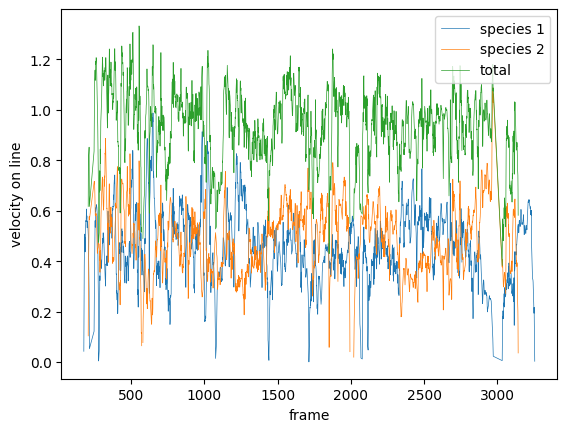

In [27]:
speed_on_line = calc_speed_on_line(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, individual_speed=individual_speed, species=species)
plot_speed_at_line(speed_on_line)
plt.show()

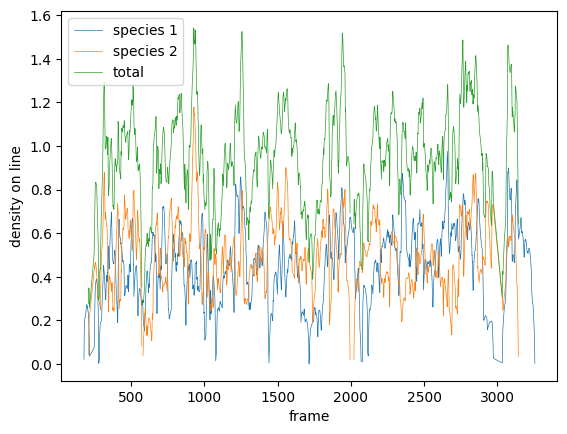

In [28]:
plot_density_at_line(calc_density_on_line(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, species=species))
plt.show()

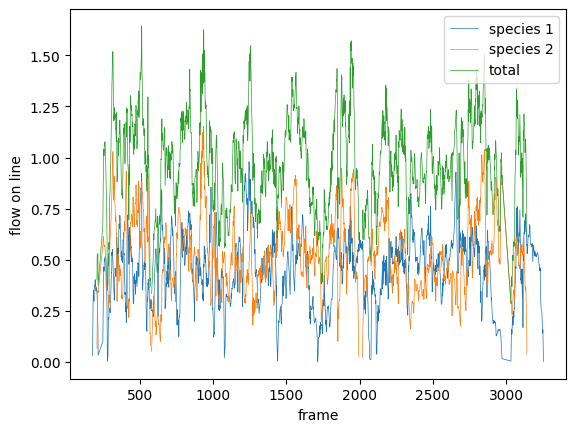

In [29]:
plot_flow_at_line(calc_flow_on_line(individual_voronoi_polygons=individual_cutoff,measurement_line=measurement_line, individual_speed=individual_speed, species=species))
plt.show()

/home/christian/PycharmProjects/PedPy/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)


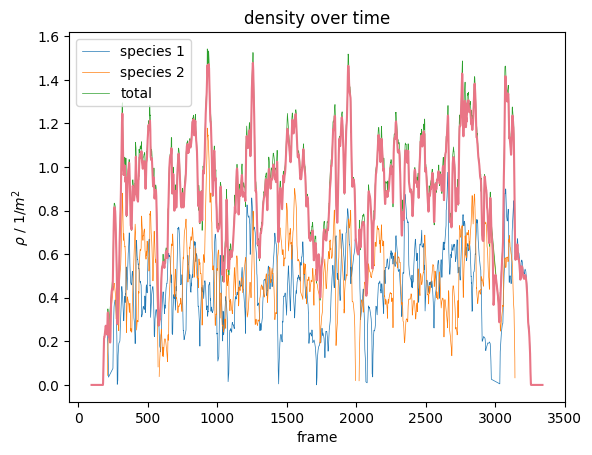

In [30]:
from pedpy.data.geometry import MeasurementArea
from pedpy.methods.density_calculator import compute_voronoi_density
from shapely import Polygon 

temp_line = measurement_line.line.buffer(0.1)
minx, miny, maxx, maxy = temp_line.bounds
polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
measurement_area = MeasurementArea(polygon)
density_voronoi, intersecting = compute_voronoi_density(
    individual_voronoi_data=individual_cutoff, measurement_area=measurement_area
)

plot_density_at_line(calc_density_on_line(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, species=species))
plot_density(density=density_voronoi, color=pedpy_red)
plt.show()

In [31]:
def expected_species(traj, spawn_1, spawn_2):
    min_idx = traj.data.groupby(ID_COL)[FRAME_COL].idxmin()
    species = traj.data.loc[min_idx, [ID_COL, FRAME_COL, POINT_COL]]
    species[SPECIES_COL] = species.apply(lambda row: calc_species(row[POINT_COL], spawn_1, spawn_2), axis=1)
    return species[[ID_COL, SPECIES_COL, FRAME_COL]]

def calc_species(pos, spawn_1: Polygon, spawn_2:Polygon):
    if spawn_1.contains(pos):
        return 1
    if spawn_2.contains(pos):
        return -1
    else:
        return 0
    

In [32]:

expected = expected_species(traj, poly1, poly2)

non_matching = expected.merge(species, on="id", suffixes=('_expected', '_species'))
non_matching = non_matching[non_matching['species_expected'] != non_matching['species_species']]
print(non_matching)

Empty DataFrame
Columns: [id, species_expected, frame, species_species]
Index: []
